# Calculate hourly capacity factor

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = "00:10:00"
cores = 24
memory = str(4 * cores) + "GB"

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=["-q normal",
                                           "-P w42",
                                           "-l ncpus="+str(cores),
                                           "-l mem="+str(memory),
                                           "-l storage=gdata/w42+gdata/rt52"],
                     local_directory="$TMPDIR",
                     job_directives_skip=["select"])

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.16:36995,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

In [6]:
%cd /g/data/w42/dr6273/work/energy_climate_modes

import functions as fn

/g/data/w42/dr6273/work/energy_climate_modes


In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
load_path = "/g/data/w42/dr6273/work/data/era5/100w/hourly/"

# Capacity factor from van der Wiel 2019

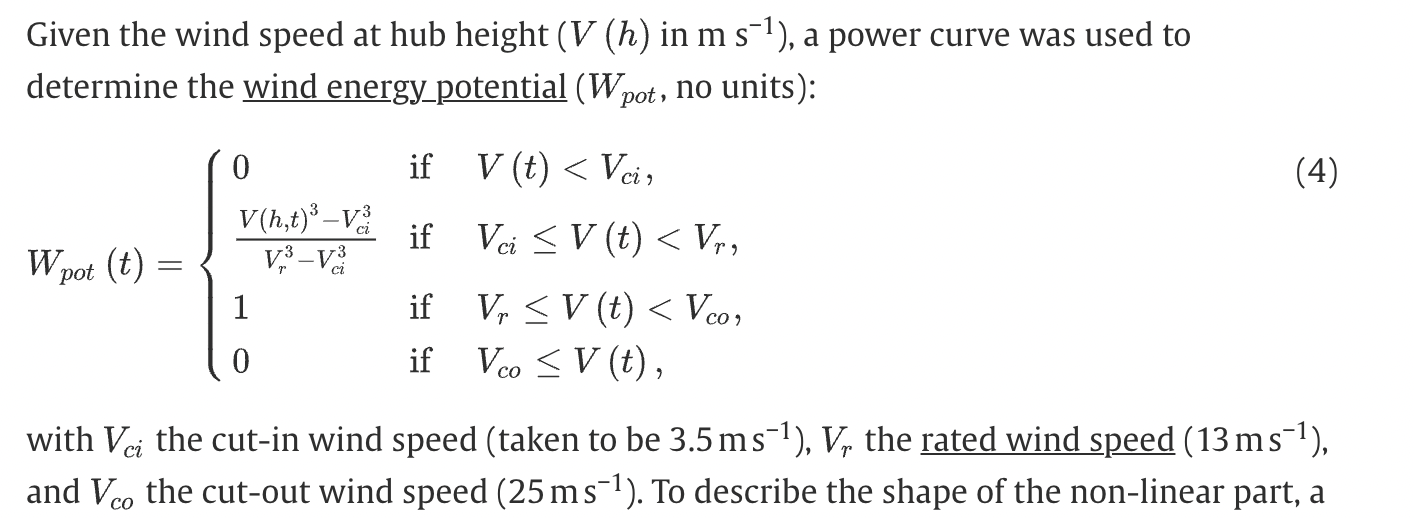

- Cut-in speed of 3 m/s here (pacific Hydro): https://onlinelibrary.wiley.com/doi/full/10.1111/aec.13220
- Cut-in, rated and cut-out of 4, 15, 25 here (slide 14; from 2008): https://www.engineersaustralia.org.au/sites/default/files/resource-files/2017-01/WindEnergyIEAustSHG060323.pdf

In [9]:
def capacity_factor_vdW(W):
    """
    Computes capacity factor from wind speed data.
    
    W: wind speed (m/s)
    """
    W_0 = 3.5 # cut-in speed (m/s)
    W_r = 13 # rated speed
    W_1 = 25 # cut-out speed (m/s)
    
    # Cubic
    c_f = (W ** 3 - W_0 ** 3) / (W_r ** 3 - W_0 ** 3)
    c_f = c_f.where(W >= W_0, 0) # Set values below cut-in to zero
    c_f = c_f.where(W < W_r, 1) # Set values above rated speed to 1
    c_f = c_f.where(W < W_1, 0) # Set values above cut-off to zero
    c_f = c_f.where(W.notnull(), np.nan) # Ensure NaNs are retained
    
    return c_f

In [10]:
write_path = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/wind/capacity_factor/van_der_Wiel"

In [11]:
years = range(1940, 2024)

In [26]:
for year in years:
    if year % 5 == 0:
        print(year)
        
    w100 = xr.open_mfdataset(
        load_path + "100w_era5_hourly_" + str(year) + "_Aus.nc",
        chunks={"lat": 50, "lon": 100}
    )["w100"]
    
    cf = capacity_factor_vdW(w100)
    cf = cf.chunk({"lat": 50, "lon": 100})
    cf = cf.to_dataset(name="capacity_factor")
    
    encoding = {
        "capacity_factor": {"dtype": "float32"}
    }
    cf.to_netcdf(
        write_path + "/wind_capacity_factor_van_der_Wiel_era5_hourly_" + str(year) + "_Aus.nc",
        mode="w",
        encoding=encoding
    )

1940
1945
1950
1955
1960
1965
1970
1975
1980
1985
1990
1995
2000
2005
2010
2015
2020


### Average capacity factor

In [17]:
vdw_cf = xr.open_mfdataset(
    write_path + "/*.nc",
    chunks={"time": 365*5}
)

In [18]:
vdw_cf

<xarray.Dataset>
Dimensions:          (lon: 181, lat: 141, time: 736344)
Coordinates:
  * lon              (lon) float32 110.0 110.2 110.5 110.8 ... 154.5 154.8 155.0
  * lat              (lat) float32 -10.0 -10.25 -10.5 ... -44.5 -44.75 -45.0
  * time             (time) datetime64[ns] 1940-01-01 ... 2023-12-31T23:00:00
Data variables:
    capacity_factor  (time, lat, lon) float32 dask.array<chunksize=(1825, 141, 181), meta=np.ndarray>

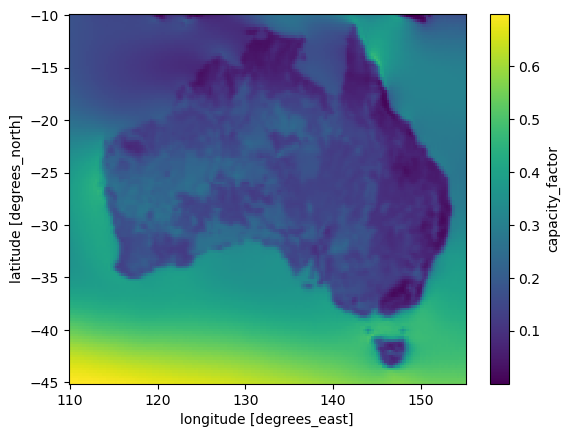

In [19]:
vdw_cf["capacity_factor"].mean("time").plot()

### 2014-2015 time series for near Sydney

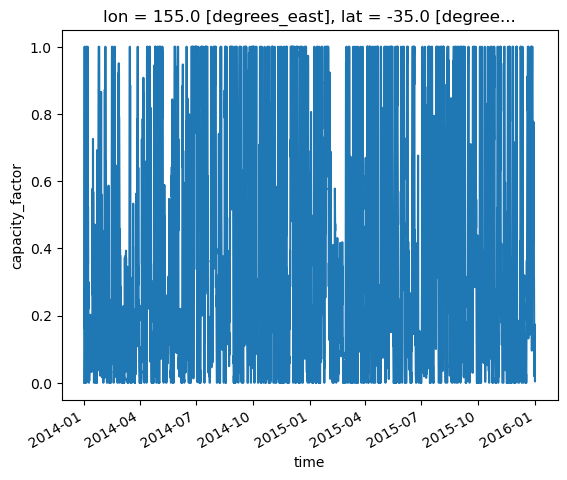

In [20]:
vdw_cf["capacity_factor"].sel(lat=-35, lon=155, time=slice("2014", "2015")).plot()

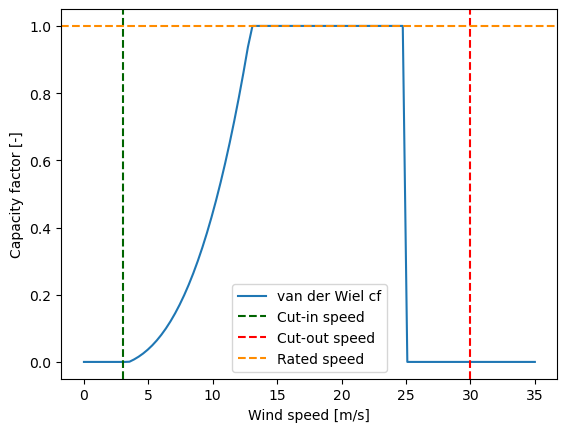

In [21]:
x = xr.DataArray(np.linspace(0, 35, 100))
p = capacity_factor_vdW(x)
# p2 = capacity_factor(x)

fig, ax = plt.subplots(1, 1)
ax.plot(x, p, label="van der Wiel cf")
ax.axvline(3, ls="--", color="darkgreen", label="Cut-in speed")
ax.axvline(30, ls="--", color="r", label="Cut-out speed")
ax.axhline(1, ls="--", color="darkorange", label="Rated speed")
ax.set_xlabel("Wind speed [m/s]")
ax.set_ylabel("Capacity factor [-]")

# ax.plot(x, p2, color="k", label="Gunn cf")

ax.legend()

# Close cluster

In [22]:
client.close()
cluster.close()